# Case study: US daily Covid 19 data

## Importing required libraries

In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from statsmodels.tsa.api                  import  ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## importing data

In [2]:
df=pd.read_csv('us_covid19_daily.csv',parse_dates=True)

In [3]:
df.head()

,Date,Positive,Hospitalized,Death
0,17-03-2020,10021,325,124
1,18-03-2020,13385,416,155
2,19-03-2020,18085,617,203
3,20-03-2020,24197,1042,273
4,21-03-2020,31013,1492,335


In [119]:
df.tail()

,Date,Positive,Hospitalized,Death
260,02-12-2020,13711156,100322,264522
261,03-12-2020,13921360,100755,267228
262,04-12-2020,14146191,101276,269791
263,05-12-2020,14357264,101190,272236
264,06-12-2020,14534035,101487,273374


### Data is collecetd for the period of 17th March 2020 to 06th December 2020. Data is collected on daily basis for Positive cases, Hospitalized and Death count

## converting data into time series

In [4]:
date = pd.date_range(start='3/17/2020', end='12/6/2020', freq='D')
date

DatetimeIndex(['2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26',
               ...
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06'],
              dtype='datetime64[ns]', length=265, freq='D')

In [5]:
df['Time_Stamp'] = pd.DataFrame(date)

In [6]:
df=df.set_index('Time_Stamp')

In [8]:
df.head()

,Date,Positive,Hospitalized,Death
Time_Stamp,,,,
2020-03-17,17-03-2020,10021,325,124
2020-03-18,18-03-2020,13385,416,155
2020-03-19,19-03-2020,18085,617,203
2020-03-20,20-03-2020,24197,1042,273
2020-03-21,21-03-2020,31013,1492,335


In [9]:
df.tail()

,Date,Positive,Hospitalized,Death
Time_Stamp,,,,
2020-12-02,02-12-2020,13711156,100322,264522
2020-12-03,03-12-2020,13921360,100755,267228
2020-12-04,04-12-2020,14146191,101276,269791
2020-12-05,05-12-2020,14357264,101190,272236
2020-12-06,06-12-2020,14534035,101487,273374


### For this case study, we will build time series model to forecast the Hospitalized count

## plotting variable Hospitalized 

<AxesSubplot:xlabel='Time_Stamp'>

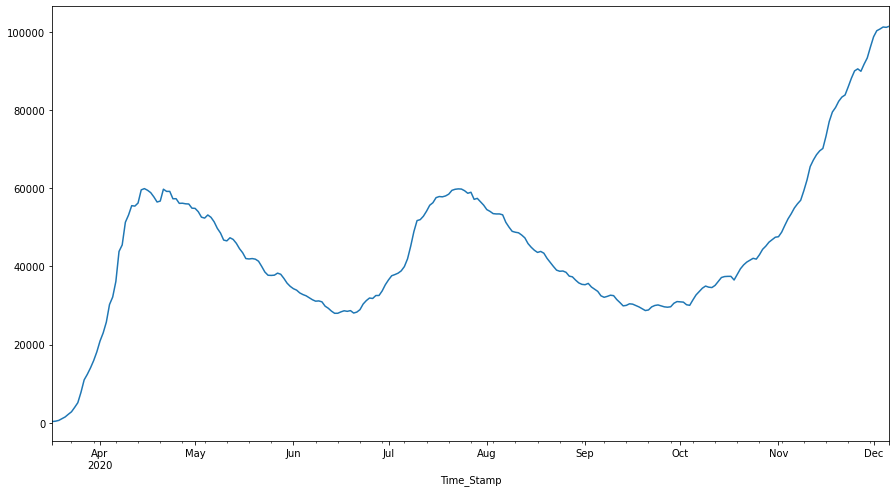

In [10]:
rcParams['figure.figsize'] = 15,8
df['Hospitalized'].plot()

In [11]:
df_final=df.drop(['Date','Positive','Death'],axis=1)

In [13]:
df_final.head()

,Hospitalized
Time_Stamp,
2020-03-17,325
2020-03-18,416
2020-03-19,617
2020-03-20,1042
2020-03-21,1492


In [12]:
df_final.tail()

,Hospitalized
Time_Stamp,
2020-12-02,100322
2020-12-03,100755
2020-12-04,101276
2020-12-05,101190
2020-12-06,101487


## Checking for Null values

In [14]:
df_final.isnull().sum()

Hospitalized    0
dtype: int64

### data does not have any missing values

## Exploratory Data Analysis

In [15]:
rcParams['figure.figsize'] = 10,6

<AxesSubplot:xlabel='Time_Stamp'>

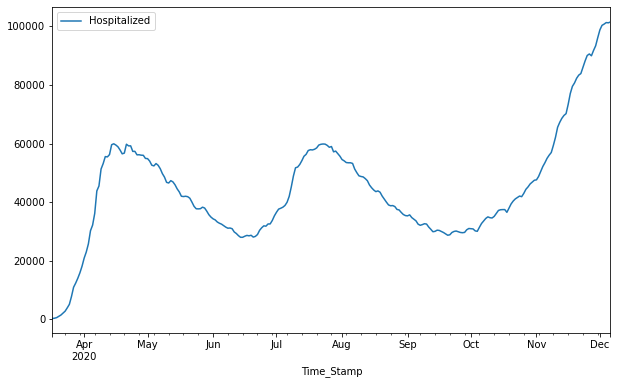

In [16]:
df_final.plot()

### plotting box-plot for distribution of data

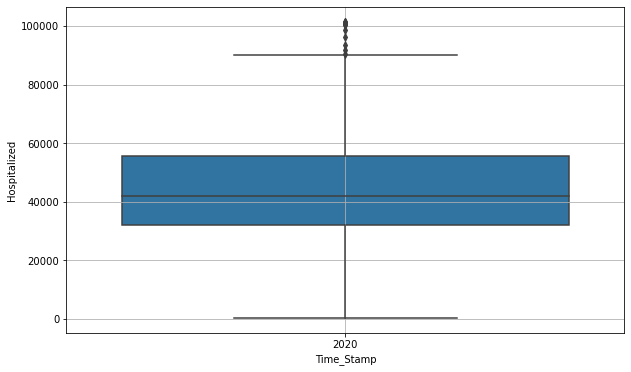

In [17]:
sns.boxplot(x = df_final.index.year,y = df_final['Hospitalized'])
plt.grid();

### data does not show any skewness

## plotting monthwise distribution

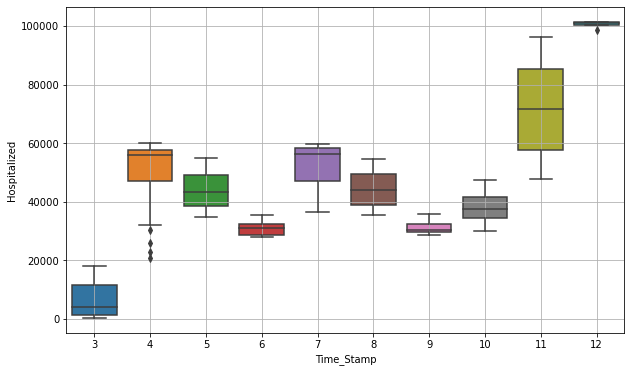

In [19]:
sns.boxplot(x = df_final.index.month,y = df_final['Hospitalized'])
plt.grid();

### High variation in data can be observed in the month of November. Few outliers are present in the month of April

## Decomposing time series

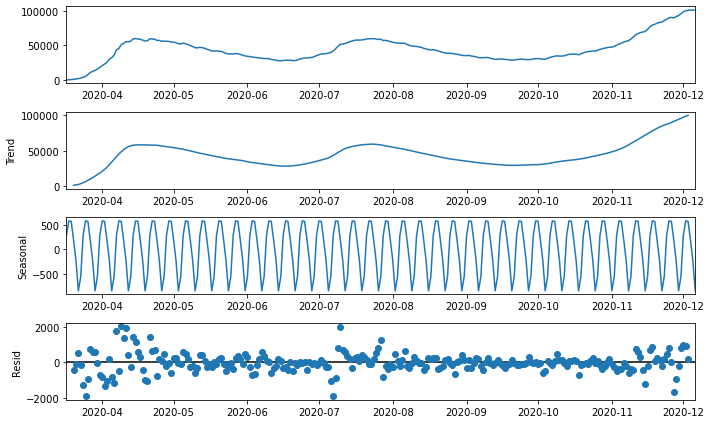

In [20]:
decomposition = seasonal_decompose(df_final, model = 'additive',period=7)
decomposition.plot()
plt.show()

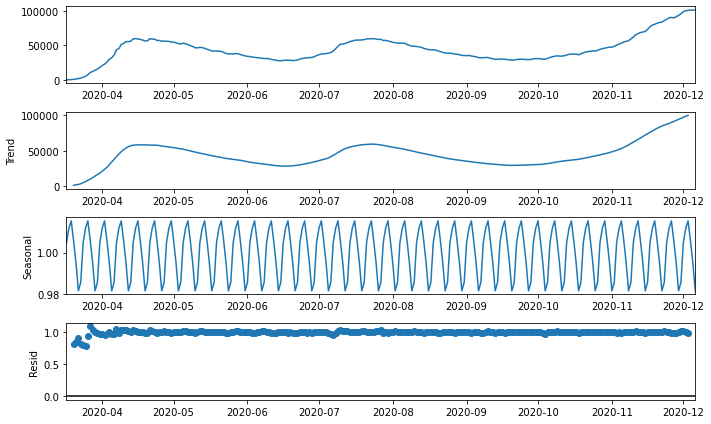

In [21]:
decomposition = seasonal_decompose(df_final, model = 'multiplicative')
decomposition.plot()
plt.show()

### Time series is showing trend as well as seasonality. Residual curve confirms that series is Multiplicative

## Looking for stationarity

### plotting monthly mean

<AxesSubplot:xlabel='Time_Stamp'>

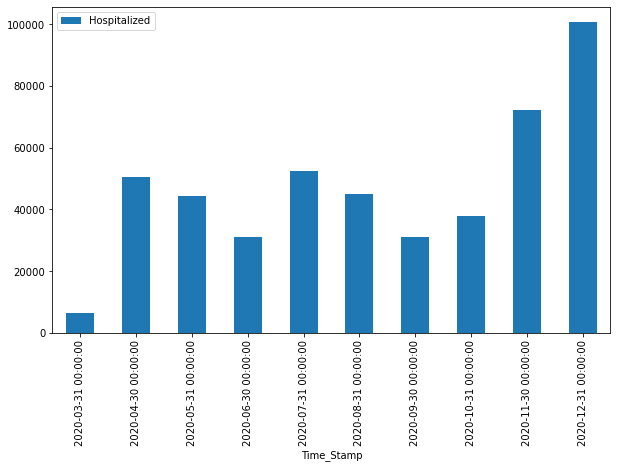

In [22]:
monthly_mean = df_final.resample('M').mean()
monthly_mean.plot.bar()

### Variation in monthly mean plot is indicating that series is non-stationary

## lets plot rolling mean and std deviation

In [23]:
rolmean = df_final.rolling(window=15).mean()
rolstd = df_final.rolling(window=15).std()

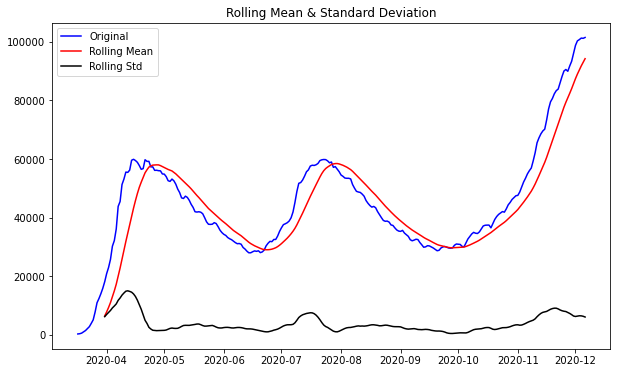

In [24]:
orig = plt.plot(df_final, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

### both rolling mean and std deviation are changing over the period of time

## statistical test to confirm the stationarity

In [25]:
observations= df_final.values
test_result = adfuller(observations)

In [26]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -1.631167
p-value: 0.466880
Critical Values:
	1%: -3.45700
	5%: -2.87327
	10%: -2.57302


### Test result confirms that series is non-stationary

## ACF and PACF plots for the series

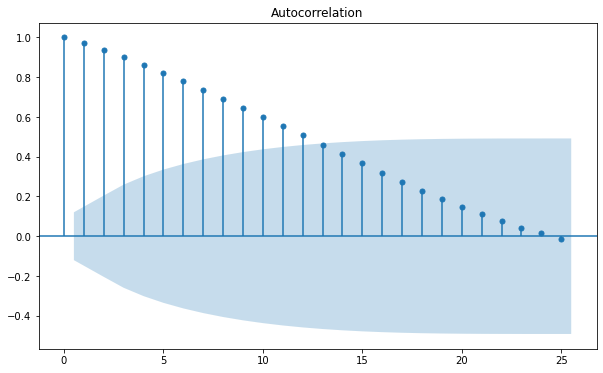

In [27]:
plot_acf(df_final);

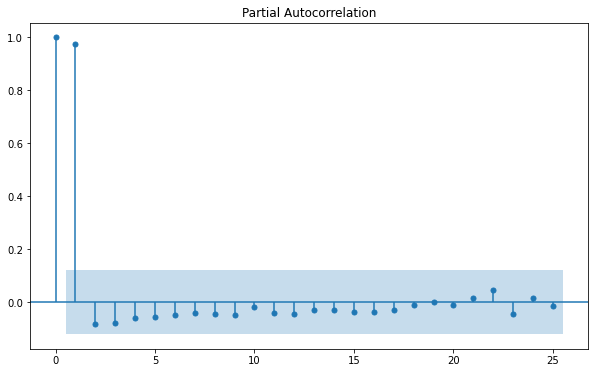

In [28]:
plot_pacf(df_final);

### ACF plot is showing gradual decay whereas PACF plot cut-offs after forst two lags.
### It seems that time series may have AR signature

## Splitting series into training and testing sets

In [29]:
df_final.head()

,Hospitalized
Time_Stamp,
2020-03-17,325
2020-03-18,416
2020-03-19,617
2020-03-20,1042
2020-03-21,1492


In [30]:
df_final.tail()

,Hospitalized
Time_Stamp,
2020-12-02,100322
2020-12-03,100755
2020-12-04,101276
2020-12-05,101190
2020-12-06,101487


In [31]:
train_end=datetime(2020,11,6)
test_end=datetime(2020,12,6)

In [32]:
train             = df_final[:train_end] 
test              = df_final[train_end + timedelta(days=1):test_end]

In [33]:
train.shape

(235, 1)

In [34]:
test.shape

(30, 1)

## Model Selection

### As the given time series is non-stationary, we will the forecasting model using ARIMA, SARIMA and SARIMAX model. We will also build the H-W forecasting model.

### Let's start by building ARIMA model -- Although the data set has some seasonality and hence ARIMA is not the right option for making the model.

## we will find the model parameters based on AIC criteria. Parameters will be  generated using combination for the given range.

In [35]:
import itertools
p = q = range(0, 2)
d= range(0,2)
pdq = list(itertools.product(p, d, q))

model_pdq = [(x[0], x[1], x[2],7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 0, 1)(0, 0, 1, 7)
Model: (0, 0, 1)(0, 1, 0, 7)
Model: (0, 1, 0)(0, 1, 1, 7)
Model: (0, 1, 0)(1, 0, 0, 7)


In [149]:
model_pdq

[(0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7)]

## Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [36]:
dfObj1 = pd.DataFrame(columns=['param', 'AIC'])
dfObj1

,param,AIC


## model parameter selection using hypertuning

In [37]:
for param in pdq:
            try:
                mod = ARIMA(train, order=param)
                results_Arima = mod.fit()
                print('ARIMA{} - AIC:{}'.format(param, results_Arima.aic))
                dfObj1 = dfObj1.append({'param':param, 'AIC': results_Arima.aic}, ignore_index=True)

            except:
                continue

ARIMA(0, 0, 0) - AIC:5135.977286705961
ARIMA(0, 0, 1) - AIC:4839.91218252999
ARIMA(0, 1, 0) - AIC:4010.2897353658404
ARIMA(0, 1, 1) - AIC:3939.069523566615
ARIMA(1, 0, 0) - AIC:4043.834437838864
ARIMA(1, 0, 1) - AIC:3969.907577134252
ARIMA(1, 1, 0) - AIC:3876.862753695441
ARIMA(1, 1, 1) - AIC:3852.8584360678137


In [38]:
dfObj1.sort_values(by=['AIC'])

,param,AIC
7,"(1, 1, 1)",3852.858436
6,"(1, 1, 0)",3876.862754
3,"(0, 1, 1)",3939.069524
5,"(1, 0, 1)",3969.907577
2,"(0, 1, 0)",4010.289735
4,"(1, 0, 0)",4043.834438
1,"(0, 0, 1)",4839.912183
0,"(0, 0, 0)",5135.977287


In [39]:
model = ARIMA(train, order=(1,1,1))

model_Arima = model.fit()

print(model_Arima.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Hospitalized   No. Observations:                  234
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1922.429
Method:                       css-mle   S.D. of innovations            893.093
Date:                Tue, 16 Mar 2021   AIC                           3852.858
Time:                        10:08:13   BIC                           3866.680
Sample:                    03-18-2020   HQIC                          3858.431
                         - 11-06-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  287.0327    338.808      0.847      0.397    -377.020     951.085
ar.L1.D.Hospitalized     0.9263      0.035     26.436      0.000       0.858       0.995
ma.L1.D.Hosp

## predicting results

In [40]:
pred_start=test.index[0]
pred_end=test.index[-1]

In [41]:
ARIMA_predictions=model_Arima.predict(start=pred_start, end=pred_end)

In [ ]:
forecast=model_Arima.forecast(len(test))

In [42]:
ARIMA_predictions

2020-11-07    1228.053512
2020-11-08    1158.660142
2020-11-09    1094.384022
2020-11-10    1034.847794
2020-11-11     979.701926
2020-11-12     928.622660
2020-11-13     881.310115
2020-11-14     837.486522
2020-11-15     796.894597
2020-11-16     759.296028
2020-11-17     724.470078
2020-11-18     692.212286
2020-11-19     662.333268
2020-11-20     634.657609
2020-11-21     609.022826
2020-11-22     585.278420
2020-11-23     563.284990
2020-11-24     542.913413
2020-11-25     524.044091
2020-11-26     506.566242
2020-11-27     490.377257
2020-11-28     475.382090
2020-11-29     461.492706
2020-11-30     448.627563
2020-12-01     436.711129
2020-12-02     425.673445
2020-12-03     415.449708
2020-12-04     405.979898
2020-12-05     397.208416
2020-12-06     389.083766
Freq: D, dtype: float64

## invert transformation

In [43]:
ARIMA_pred=ARIMA_predictions.cumsum()
ARIMA_pred=pd.DataFrame(ARIMA_pred,columns=train.columns)

In [44]:
df_fc = ARIMA_pred.copy()
columns = train.columns
for col in columns:        
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)]

In [45]:
df_fc.head()

,Hospitalized,Hospitalized_forecast
2020-11-07,1228.053512,56177.053512
2020-11-08,2386.713654,57335.713654
2020-11-09,3481.097677,58430.097677
2020-11-10,4515.945471,59464.945471
2020-11-11,5495.647397,60444.647397


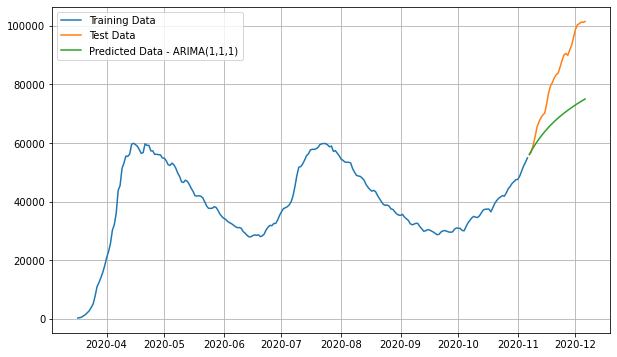

In [46]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df_fc['Hospitalized_forecast'],label='Predicted Data - ARIMA(1,1,1)')
plt.legend(loc='best')
plt.grid();

## finding model residuals

In [47]:
residuals = test.Hospitalized - df_fc['Hospitalized_forecast']

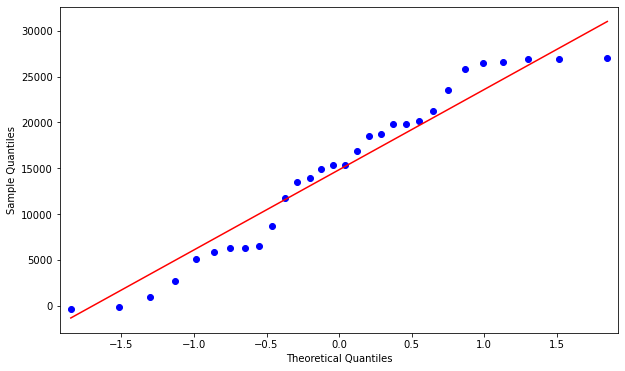

In [48]:
qqplot(residuals,line="s");

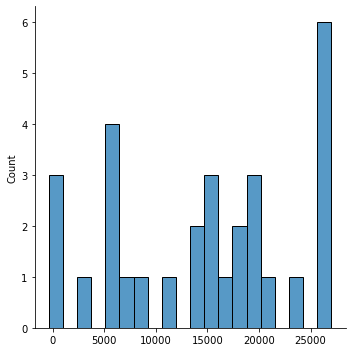

In [49]:
sns.displot(residuals,bins=20)

### distribution of residual plot confirms that model does not fit well with the seasonality series

## Calculating RSME and MAPE 

In [50]:
from math import sqrt
from sklearn.metrics import  mean_squared_error
rmse = sqrt(mean_squared_error(test.Hospitalized,df_fc['Hospitalized_forecast']))
print(rmse)

17222.569806479853


In [51]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [52]:
mape = MAPE(test['Hospitalized'].values,df_fc['Hospitalized_forecast'].values)
print(mape)

16.677049534161664


## creating new dataframe for storing the results

In [53]:
resultsDf = pd.DataFrame({'Test RMSE': rmse,'Test MAPE':mape}
                           ,index=['ARIMA(1,1,1)'])

resultsDf

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",17222.569806,16.67705


## Now to include seasonality, we will use SARIMA model

## we will find the model parameters based on AIC criteria. Parameters will be  generated using combination for the given range.

In [54]:
import itertools
p = q = range(0, 2)
d= range(0,2)
pdq = list(itertools.product(p, d, q))

model_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 0, 1)(0, 0, 1, 7)
Model: (0, 0, 1)(0, 1, 0, 7)
Model: (0, 1, 0)(0, 1, 1, 7)
Model: (0, 1, 0)(1, 0, 0, 7)


## Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [55]:
dfObj2 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
dfObj2

,param,seasonal,AIC


## model parameter selection using hypertuning

In [56]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = mod.fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        dfObj2 = dfObj2.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:5648.332882628767
SARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:5329.355924738498
SARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:4680.257455970985
SARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:4461.064432461721
SARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:4701.52192186462
SARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:4720.920611046705
SARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:4377.198345433431
SARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:4336.644807529079
SARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:5455.686974071585
SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:5256.025552322466
SARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:4403.639574501963
SARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:4170.131835327844
SARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:5284.409588072873
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:5239.482293912001
SARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:4173.930597384604
SARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:4124.0946284032725
SARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:3999.9926692527033
SARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:3815.446740045441
SARIMA(0, 1, 0)x(0, 1, 0, 7

## sorting parameters for best AIC score

In [57]:
dfObj2.sort_values(by=['AIC'])

,param,seasonal,AIC
63,"(1, 1, 1)","(1, 1, 1, 7)",3538.575787
59,"(1, 1, 1)","(0, 1, 1, 7)",3539.139280
62,"(1, 1, 1)","(1, 1, 0, 7)",3586.225836
55,"(1, 1, 0)","(1, 1, 1, 7)",3599.899086
51,"(1, 1, 0)","(0, 1, 1, 7)",3601.347493
...,...,...,...
9,"(0, 0, 1)","(0, 0, 1, 7)",5256.025552
12,"(0, 0, 1)","(1, 0, 0, 7)",5284.409588
1,"(0, 0, 0)","(0, 0, 1, 7)",5329.355925
8,"(0, 0, 1)","(0, 0, 0, 7)",5455.686974


### SARIMA model parameters are selected as (1,1,1)(1,1,1,7)

In [58]:
model = sm.tsa.statespace.SARIMAX(train,
                                order=(1,1,1),
                                seasonal_order=(1,1,1,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_Sarima = model.fit()
print(model_Sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Hospitalized   No. Observations:                  235
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1764.288
Date:                           Tue, 16 Mar 2021   AIC                           3538.576
Time:                                   10:14:26   BIC                           3555.498
Sample:                               03-17-2020   HQIC                          3545.411
                                    - 11-06-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9437      0.021     46.015      0.000       0.903       0.984
ma.L1         -0.5652      0.042    -13.313

In [59]:
SARIMA_predictions=model_Sarima.predict(start=pred_start, end=pred_end)

## plotting model predictions

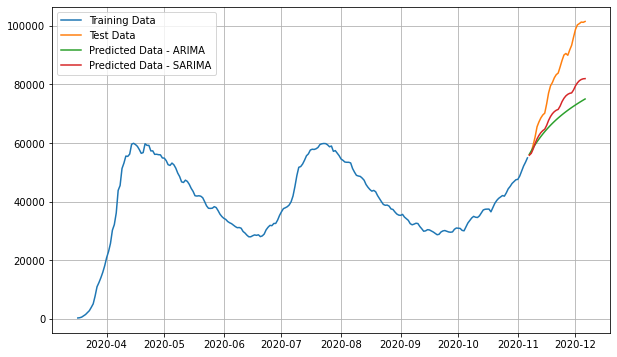

In [60]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df_fc['Hospitalized_forecast'],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.legend(loc='best')
plt.grid();

### It can be observed that SARIMA model is showing good seasonal considerations

## finding RSMA and MAPE

In [61]:
rmse = sqrt(mean_squared_error(test.Hospitalized,SARIMA_predictions))
print(rmse)

12901.96920698507


In [62]:
mape = MAPE(test.Hospitalized,SARIMA_predictions)
print(mape)

12.732866962041992


In [63]:
resultsDfsarima = pd.DataFrame({'Test RMSE': rmse, 'Test MAPE':mape}
                           ,index=['SARIMA(1, 1, 1)(1, 1, 1)7'])

resultsDf = pd.concat([resultsDf, resultsDfsarima])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",17222.569806,16.677050
"SARIMA(1, 1, 1)(1, 1, 1)7",12901.969207,12.732867


## model residual analysis

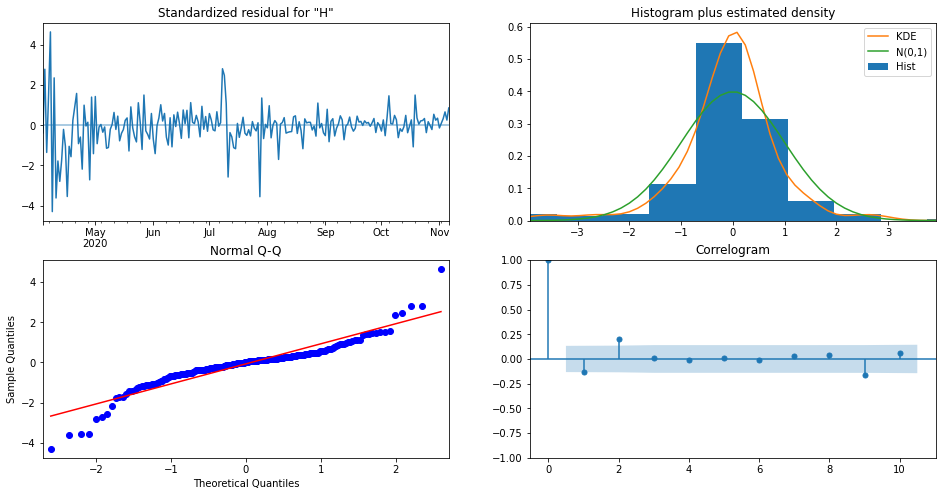

In [64]:
model_Sarima.plot_diagnostics(figsize=(16, 8))
plt.show()

### It can be observed that Model residuals are normally distributed and ACF plot also confirms that residuals are random

## We will build SARIMAX model for forecasting Hospitalized count. For SARIMAX model,we will use Positive count as exog variable

In [65]:
ex=df[['Positive']]

In [66]:
ex

,Positive
Time_Stamp,
2020-03-17,10021
2020-03-18,13385
2020-03-19,18085
2020-03-20,24197
2020-03-21,31013
...,...
2020-12-02,13711156
2020-12-03,13921360
2020-12-04,14146191


## splitting exog variable into training and testing set

In [67]:
ex_train             = ex[:train_end]
ex_test              = ex[train_end + timedelta(days=1):test_end]

### Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [68]:
dfObj3 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
dfObj3

,param,seasonal,AIC


## model parameter selection using hypertuning

In [69]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,exog=ex_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMAX = mod.fit()
        print('SARIMA{}{} - AIC:{}'.format(param, param_seasonal, results_SARIMAX.aic))
        dfObj3 = dfObj3.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMAX.aic}, ignore_index=True)

SARIMA(0, 0, 0)(0, 0, 0, 7) - AIC:6471.655187973391
SARIMA(0, 0, 0)(0, 0, 1, 7) - AIC:5112.807499140348
SARIMA(0, 0, 0)(0, 1, 0, 7) - AIC:5674.544765008526
SARIMA(0, 0, 0)(0, 1, 1, 7) - AIC:4459.058775141008
SARIMA(0, 0, 0)(1, 0, 0, 7) - AIC:4686.832792303774
SARIMA(0, 0, 0)(1, 0, 1, 7) - AIC:4707.483925219727
SARIMA(0, 0, 0)(1, 1, 0, 7) - AIC:4366.739432168464
SARIMA(0, 0, 0)(1, 1, 1, 7) - AIC:4392.854888450027
SARIMA(0, 0, 1)(0, 0, 0, 7) - AIC:5236.9512558802
SARIMA(0, 0, 1)(0, 0, 1, 7) - AIC:5044.6406626628905
SARIMA(0, 0, 1)(0, 1, 0, 7) - AIC:4492.648197772189
SARIMA(0, 0, 1)(0, 1, 1, 7) - AIC:4606.715443625197
SARIMA(0, 0, 1)(1, 0, 0, 7) - AIC:5072.4254550090645
SARIMA(0, 0, 1)(1, 0, 1, 7) - AIC:5340.504099146533
SARIMA(0, 0, 1)(1, 1, 0, 7) - AIC:4412.100641638546
SARIMA(0, 0, 1)(1, 1, 1, 7) - AIC:4323.03766941172
SARIMA(0, 1, 0)(0, 0, 0, 7) - AIC:5029.5794749540055
SARIMA(0, 1, 0)(0, 0, 1, 7) - AIC:3815.2797783242086
SARIMA(0, 1, 0)(0, 1, 0, 7) - AIC:3810.1050075808885
SARIMA(0, 

## sorting parameters for AIC score

In [70]:
dfObj3.sort_values(by=['AIC'])

,param,seasonal,AIC
63,"(1, 1, 1)","(1, 1, 1, 7)",3536.918928
59,"(1, 1, 1)","(0, 1, 1, 7)",3537.161487
62,"(1, 1, 1)","(1, 1, 0, 7)",3593.484822
51,"(1, 1, 0)","(0, 1, 1, 7)",3599.278102
55,"(1, 1, 0)","(1, 1, 1, 7)",3610.115694
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 7)",5112.807499
8,"(0, 0, 1)","(0, 0, 0, 7)",5236.951256
13,"(0, 0, 1)","(1, 0, 1, 7)",5340.504099
2,"(0, 0, 0)","(0, 1, 0, 7)",5674.544765


## We will build SARIMAX model of order (1,1,1)(0,1,1,7)

In [71]:
model = sm.tsa.statespace.SARIMAX(train,exog=ex_train,
                                order=(1,1,1),
                                seasonal_order=(1,1,1,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_sarimax = model.fit()
print(model_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Hospitalized   No. Observations:                  235
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1762.459
Date:                           Tue, 16 Mar 2021   AIC                           3536.919
Time:                                   10:22:58   BIC                           3557.226
Sample:                               03-17-2020   HQIC                          3545.121
                                    - 11-06-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Positive       0.0200      0.014      1.432      0.152      -0.007       0.047
ar.L1          0.9437      0.021     44.185

### model predictions

In [72]:
SARIMAX_predictions=model_sarimax.predict(start=pred_start, end=pred_end,exog=ex_test)

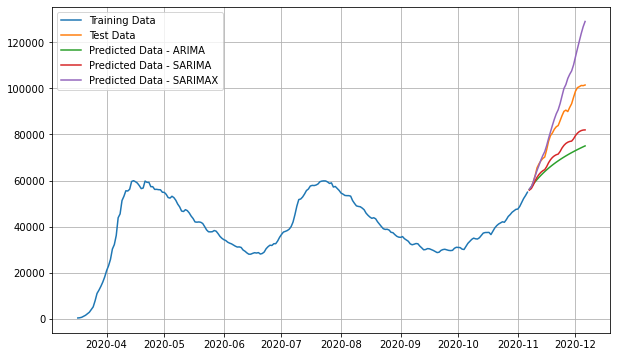

In [73]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df_fc['Hospitalized_forecast'],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.plot(test.index,SARIMAX_predictions,label='Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.grid();

### SARIMAX model is predicting results quite close to actual data

## Residual analysis

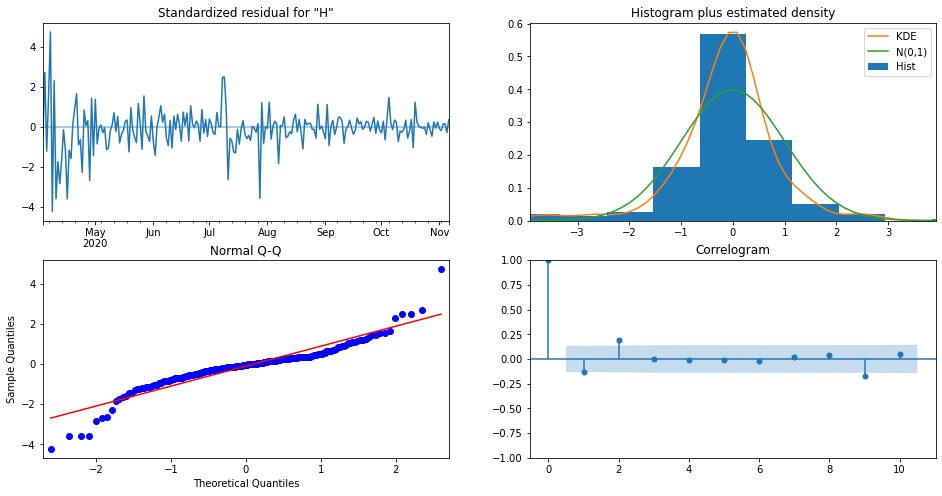

In [74]:
model_sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

### It can be observed that Model residuals are normally distributed and ACF plot also confirms that residuals are random

## Finding RSMA and MAPE

In [75]:
rmse = sqrt(mean_squared_error(test.Hospitalized,SARIMAX_predictions))
print(rmse)

11709.443638505812


In [76]:
mape = MAPE(test.Hospitalized,SARIMAX_predictions)
print(mape)

8.98782952467951


In [77]:
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['SARIMAX(1, 1, 1)(1, 1, 1)7'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",17222.569806,16.677050
"SARIMA(1, 1, 1)(1, 1, 1)7",12901.969207,12.732867
"SARIMAX(1, 1, 1)(1, 1, 1)7",11709.443639,8.987830


## As series has seasonality and trend, lets try H-W model for forecasting Hospitalized count

In [93]:
model_TES = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')

In [94]:
model_TES = model_TES.fit(optimized=True)
model_TES.summary()

Dep. Variable:,Hospitalized,No. Observations:,235
Model:,ExponentialSmoothing,SSE,139965968.248
Optimized:,True,AIC,3146.871
Trend:,Additive,BIC,3184.927
Seasonal:,Additive,AICC,3148.518
Seasonal Periods:,7,Date:,"Tue, 16 Mar 2021"
Box-Cox:,False,Time:,10:29:01
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8947529,alpha,True
smoothing_trend,0.4089930,beta,True


In [95]:
TES_predictions =  model_TES.forecast(len(test))

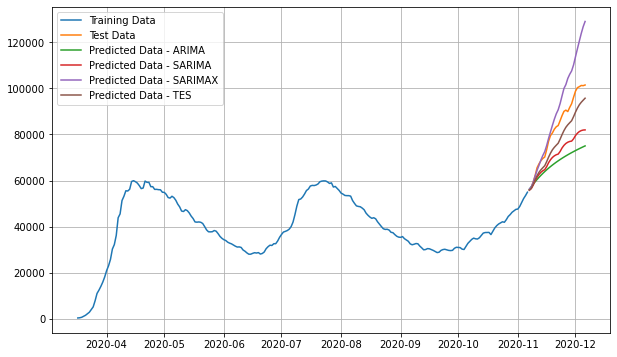

In [96]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df_fc['Hospitalized_forecast'],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.plot(test.index,SARIMAX_predictions,label='Predicted Data - SARIMAX')
plt.plot(test.index,TES_predictions,label='Predicted Data - TES')
plt.legend(loc='best')
plt.grid();

## finding RSME and MAPE

In [97]:
rmse = sqrt(mean_squared_error(test.Hospitalized,TES_predictions))
print(rmse)

6473.132560612063


In [98]:
mape = MAPE(test['Hospitalized'].values,TES_predictions.values)
print(mape)

6.9189679523465415


In [84]:
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['TES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",17222.569806,16.677050
"SARIMA(1, 1, 1)(1, 1, 1)7",12901.969207,12.732867
"SARIMAX(1, 1, 1)(1, 1, 1)7",11709.443639,8.987830
TES,6473.132561,6.918968


## Based on MAPE, selecting H-W model

In [99]:
model_TES = ExponentialSmoothing(df_final,trend='additive',seasonal='additive',initialization_method='estimated')

In [100]:
model_TES = model_TES.fit(optimized=True)

In [101]:
model_TES.summary()

Dep. Variable:,Hospitalized,No. Observations:,265
Model:,ExponentialSmoothing,SSE,162264376.345
Optimized:,True,AIC,3553.127
Trend:,Additive,BIC,3592.504
Seasonal:,Additive,AICC,3554.577
Seasonal Periods:,7,Date:,"Tue, 16 Mar 2021"
Box-Cox:,False,Time:,10:29:41
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8903442,alpha,True
smoothing_trend,0.4020128,beta,True


In [102]:
forecast= model_TES.forecast(30)

In [104]:
forecast

2020-12-07    102896.927104
2020-12-08    104280.023158
2020-12-09    105246.768825
2020-12-10    105716.581235
2020-12-11    106264.070084
2020-12-12    106752.834377
2020-12-13    106947.793855
2020-12-14    108371.112078
2020-12-15    109754.208131
2020-12-16    110720.953798
2020-12-17    111190.766209
2020-12-18    111738.255058
2020-12-19    112227.019351
2020-12-20    112421.978829
2020-12-21    113845.297051
2020-12-22    115228.393105
2020-12-23    116195.138772
2020-12-24    116664.951183
2020-12-25    117212.440031
2020-12-26    117701.204325
2020-12-27    117896.163803
2020-12-28    119319.482025
2020-12-29    120702.578079
2020-12-30    121669.323745
2020-12-31    122139.136156
2021-01-01    122686.625005
2021-01-02    123175.389298
2021-01-03    123370.348776
2021-01-04    124793.666998
2021-01-05    126176.763052
Freq: D, dtype: float64

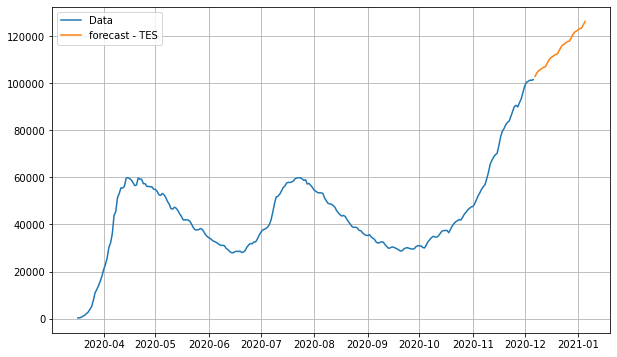

In [103]:
plt.plot(df_final,label='Data')
plt.plot(forecast,label='forecast - TES')
plt.legend(loc='best')
plt.grid();

# END